### Introduction:
##### This notebook delves into covariate shift experiments within a linear data distribution setting.

### Methods Considered:
##### a) MDI+ ("All" version) with and without raw features
##### b) LFI ("none" version) with and without raw features
##### c) Treeshap

In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
sys.path.append("../../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, roc_auc_score, mean_squared_error

from imodels.importance import RandomForestPlusRegressor, RandomForestPlusClassifier, \
    RidgeRegressorPPM, LassoRegressorPPM, IdentityTransformer
from imodels.importance.rf_plus import _fast_r2_score
import seaborn as sns
import shap
import sklearn
import copy
coolwarm_camp = sns.color_palette("coolwarm", as_cmap=True)

In [2]:
def sample_normal_X_subgroups(n, d, mean, scale):
    """
    :param n: Number of samples
    :param d: Number of features
    :param mean: Nested list of mean of normal distribution for each subgroup
    :param scale: Nested ist of scale of normal distribution for each subgroup
    :return:
    """
    np.random.seed(0)
    assert len(mean[0]) == len(scale[0]) == d
    num_groups = len(mean)
    result = []
    group_size = n // num_groups
    for i in range(num_groups):
        X = np.zeros((group_size, d))
        for j in range(d):
            X[:, j] = np.random.normal(mean[i][j], scale[i][j], size=group_size)
        result.append(X)
    return np.vstack(result)

In [3]:
def tree_shap_local(X, y, fit):
    """
    Compute average treeshap value across observations.
    Larger absolute values indicate more important features.
    :param X: design matrix
    :param y: response
    :param fit: fitted model of interest (tree-based)
    :return: dataframe of shape: (n_samples, n_features)
    """
    explainer = shap.TreeExplainer(fit)
    shap_values = explainer.shap_values(X, check_additivity=False)
    if sklearn.base.is_classifier(fit):
        # Shape values are returned as a list of arrays, one for each class
        def add_abs(a, b):
            return abs(a) + abs(b)
        results = reduce(add_abs, shap_values)
    else:
        results = shap_values
    result_table = pd.DataFrame(results, columns=[f'Feature_{i}' for i in range(X.shape[1])])

    return result_table

# Two Groups Analysis 1
Sample Size: 200  
Features: 10  
Signal Features: 5  
First group: all 10 features ~ N(0,1)  
Second group: all 10 features ~ N(10,1)  

In [4]:
n = 200
d = 10
mean = [[0]*10, [10]*10]
scale = [[1]*10,[1]*10]
s = 5
X = sample_normal_X_subgroups(n, d, mean, scale)
beta = np.concatenate((np.ones(s), np.zeros(d-s)))
y = np.matmul(X, beta)

# Without Raw

In [5]:
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_plus_model = RandomForestPlusRegressor(rf_model=copy.deepcopy(rf_regressor), include_raw=False)
rf_plus_model.fit(X, y)

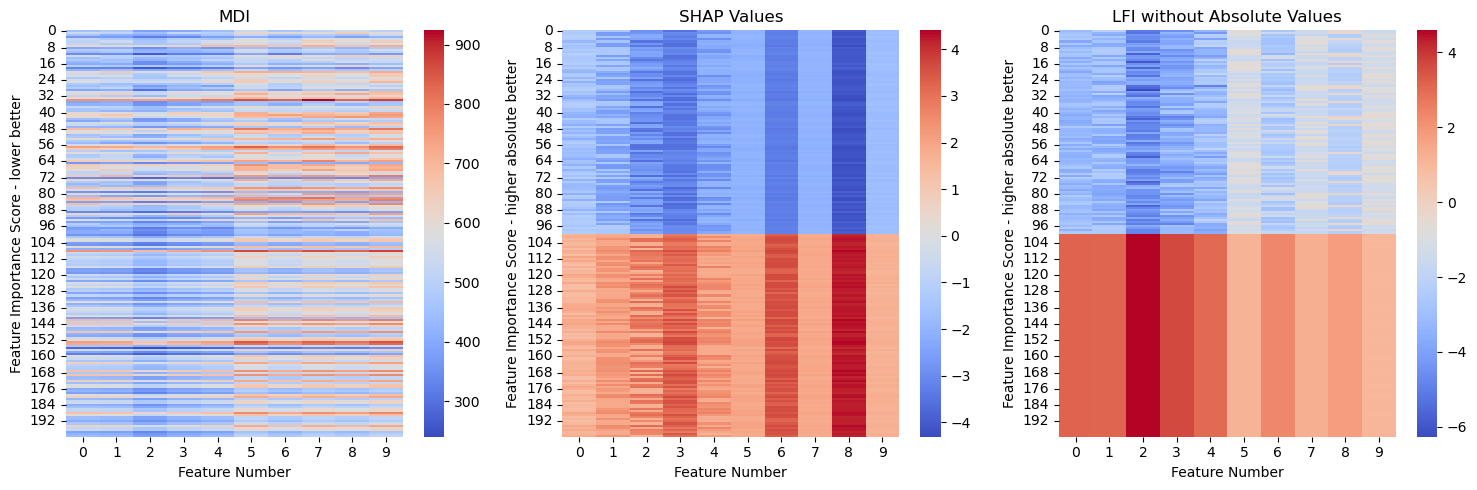

In [6]:
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X, y, local_scoring_fns=mean_squared_error, version="all", lfi=False)
plt.figure(figsize=(15, 5))  
plt.subplot(1, 3, 1)
sns.heatmap(mdi_plus_scores["local"], cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("MDI")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - lower better")

rf_regressor.fit(X, y)
shap_val = tree_shap_local(X, y, rf_regressor)
shap_val.columns = [f'{i}' for i in range(X.shape[1])]
plt.subplot(1, 3, 2)
sns.heatmap(shap_val, cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("SHAP Values")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - higher absolute better")

mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X, y, lfi=True, lfi_abs="none")
plt.subplot(1, 3, 3)
sns.heatmap(mdi_plus_scores["lfi"], cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("LFI without Absolute Values")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - higher absolute better")

plt.tight_layout() 
plt.show()

# With Raw

In [7]:
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_plus_model = RandomForestPlusRegressor(rf_model=copy.deepcopy(rf_regressor), include_raw=True)
rf_plus_model.fit(X, y)

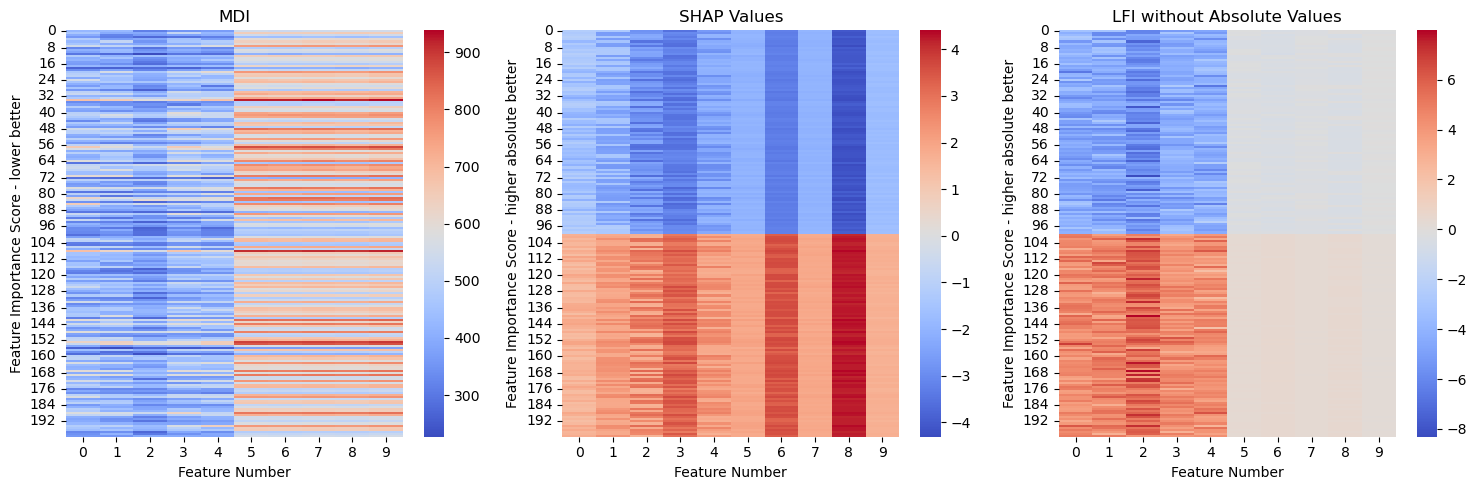

In [8]:
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X, y, local_scoring_fns=mean_squared_error, version="all", lfi=False)
plt.figure(figsize=(15, 5)) 
plt.subplot(1, 3, 1)
sns.heatmap(mdi_plus_scores["local"], cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("MDI")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - lower better")

rf_regressor.fit(X, y)
shap_val = tree_shap_local(X, y, rf_regressor)
shap_val.columns = [f'{i}' for i in range(X.shape[1])]
plt.subplot(1, 3, 2)
sns.heatmap(shap_val, cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("SHAP Values")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - higher absolute better")

mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X, y, lfi=True, lfi_abs="none")
plt.subplot(1, 3, 3)
sns.heatmap(mdi_plus_scores["lfi"], cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("LFI without Absolute Values")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - higher absolute better")

plt.tight_layout() 
plt.show()

# Two Groups Analysis 2
Sample Size: 200  
Features: 10  
Signal Features: 5  
First group: signal features ~ N(0,1), other features ~ N(0,1)  
Second group: signal features ~ N(10,1), other features ~ N(0,1)  

In [9]:
n = 200
d = 10
mean = [[0]*10, [10]*5 + [0]*5]
scale = [[1]*10,[1]*10]
s = 5
X = sample_normal_X_subgroups(n, d, mean, scale)     
beta = np.concatenate((np.ones(s), np.zeros(d-s)))
y = np.matmul(X, beta)

# Without Raw

In [10]:
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_plus_model = RandomForestPlusRegressor(rf_model=copy.deepcopy(rf_regressor), include_raw=False)
rf_plus_model.fit(X, y)

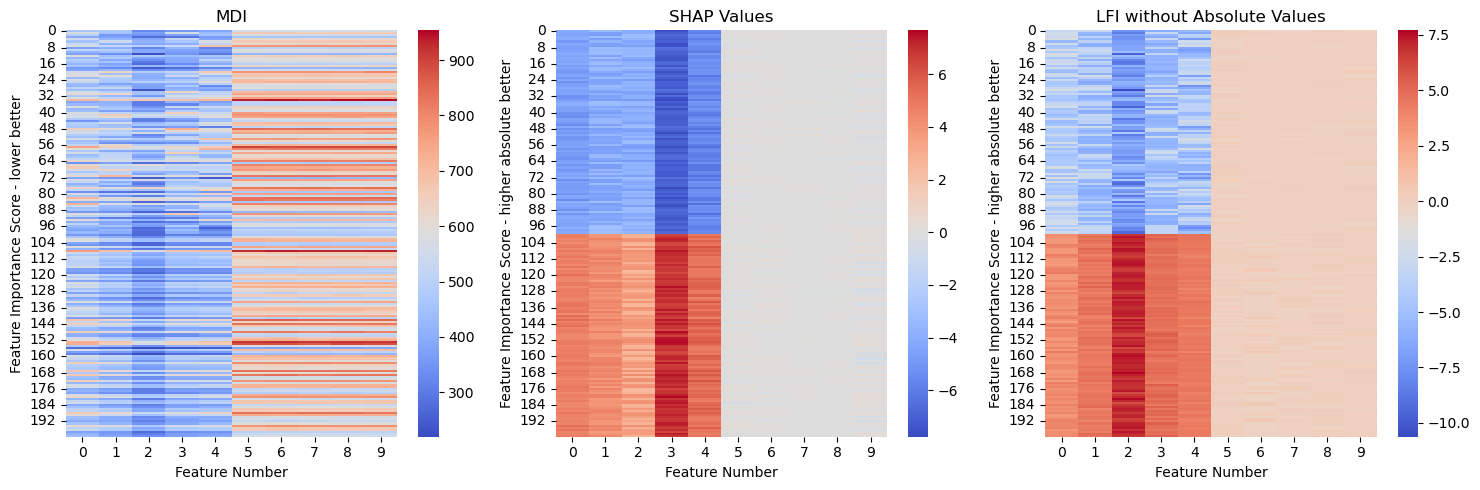

In [11]:
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X, y, local_scoring_fns=mean_squared_error, version="all", lfi=False)
plt.figure(figsize=(15, 5)) 
plt.subplot(1, 3, 1)
sns.heatmap(mdi_plus_scores["local"], cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("MDI")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - lower better")

rf_regressor.fit(X, y)
shap_val = tree_shap_local(X, y, rf_regressor)
shap_val.columns = [f'{i}' for i in range(X.shape[1])]
plt.subplot(1, 3, 2)
sns.heatmap(shap_val, cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("SHAP Values")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - higher absolute better")

mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X, y, lfi=True, lfi_abs="none")
plt.subplot(1, 3, 3)
sns.heatmap(mdi_plus_scores["lfi"], cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("LFI without Absolute Values")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - higher absolute better")

plt.tight_layout() 
plt.show()

# With Raw

In [12]:
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_plus_model = RandomForestPlusRegressor(rf_model=copy.deepcopy(rf_regressor), include_raw=True)
rf_plus_model.fit(X, y)

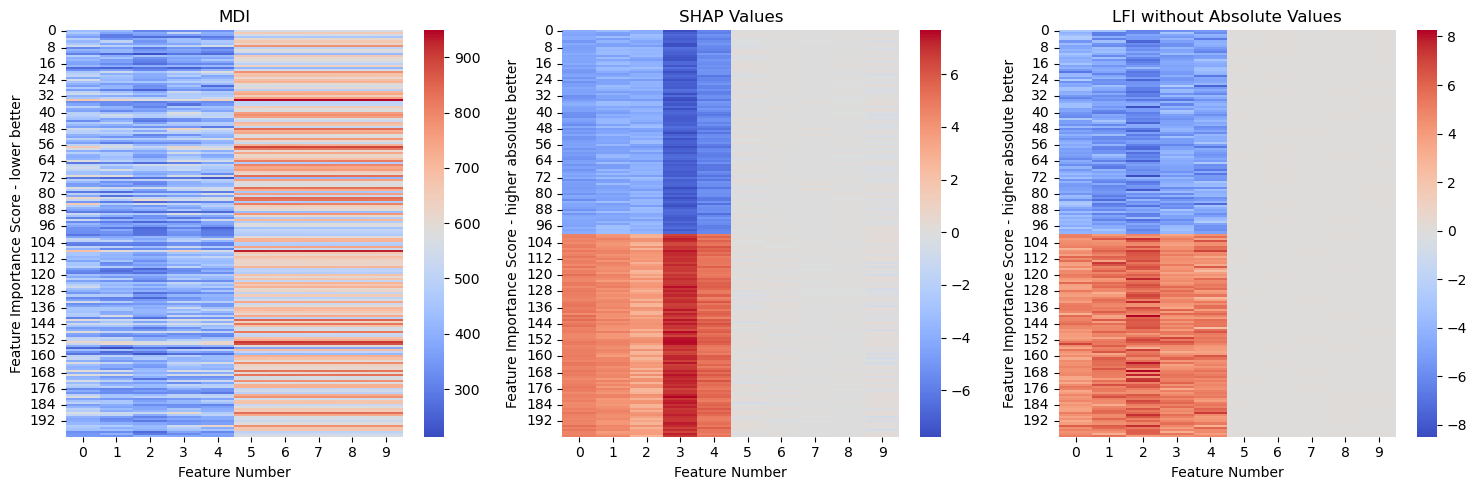

In [13]:
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X, y, local_scoring_fns=mean_squared_error, version="all", lfi=False)
plt.figure(figsize=(15, 5))  # Adjusted width to accommodate three plots side-by-side
plt.subplot(1, 3, 1)
sns.heatmap(mdi_plus_scores["local"], cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("MDI")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - lower better")

rf_regressor.fit(X, y)
shap_val = tree_shap_local(X, y, rf_regressor)
shap_val.columns = [f'{i}' for i in range(X.shape[1])]
plt.subplot(1, 3, 2)
sns.heatmap(shap_val, cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("SHAP Values")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - higher absolute better")

mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X, y, lfi=True, lfi_abs="none")
plt.subplot(1, 3, 3)
sns.heatmap(mdi_plus_scores["lfi"], cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("LFI without Absolute Values")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - higher absolute better")

plt.tight_layout() 
plt.show()

# Two Groups Variance Analysis

# Three Groups Analysis
Sample Size: 300  
Features: 10  
Signal Features: 5  
First group: signal features ~ N(0,1), other features ~ N(0,1)  
Second group: signal features ~ N(10,1), other features ~ N(0,1)  
Third group: signal features ~ N(20,1), other features ~ N(0,1)  

In [14]:
n = 300
d = 10
mean = [[0]*5+[0]*5,[10]*5+[0]*5,[20]*5+[0]*5]
scale = [[1]*10,[1]*10,[1]*10]
s = 5
X = sample_normal_X_subgroups(n, d, mean, scale)
beta = np.concatenate((np.ones(s), np.zeros(d-s)))
y = np.matmul(X, beta)

# Without Raw

In [15]:
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_plus_model = RandomForestPlusRegressor(rf_model=copy.deepcopy(rf_regressor), include_raw=False)
rf_plus_model.fit(X, y)

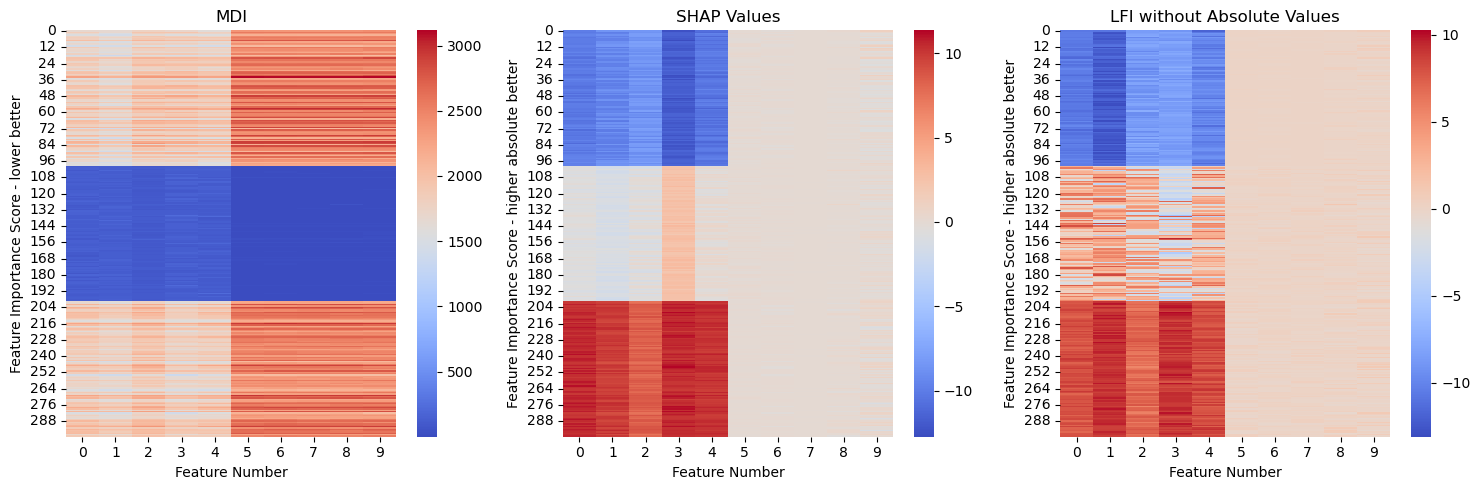

In [16]:
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X, y, local_scoring_fns=mean_squared_error, version="all", lfi=False)
plt.figure(figsize=(15, 5))  # Adjusted width to accommodate three plots side-by-side
plt.subplot(1, 3, 1)
sns.heatmap(mdi_plus_scores["local"], cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("MDI")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - lower better")

rf_regressor.fit(X, y)
shap_val = tree_shap_local(X, y, rf_regressor)
shap_val.columns = [f'{i}' for i in range(X.shape[1])]
plt.subplot(1, 3, 2)
sns.heatmap(shap_val, cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("SHAP Values")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - higher absolute better")

mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X, y, lfi=True, lfi_abs="none")
plt.subplot(1, 3, 3)
sns.heatmap(mdi_plus_scores["lfi"], cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("LFI without Absolute Values")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - higher absolute better")

plt.tight_layout() 
plt.show()

# With Raw

In [17]:
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_plus_model = RandomForestPlusRegressor(rf_model=copy.deepcopy(rf_regressor), include_raw=True)
rf_plus_model.fit(X, y)

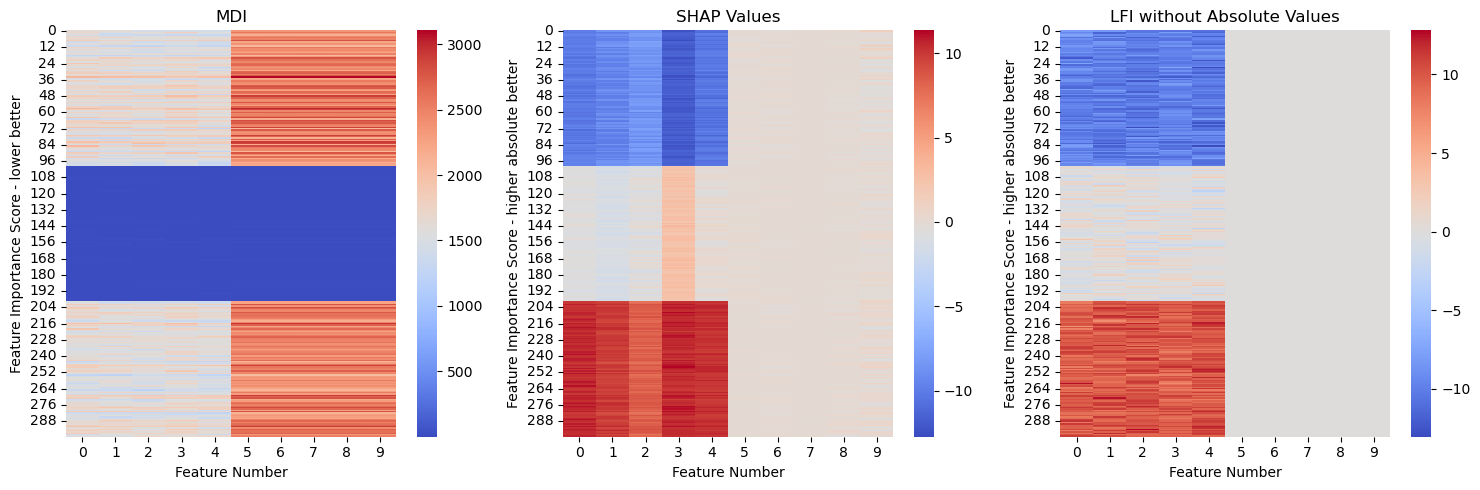

In [18]:
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X, y, local_scoring_fns=mean_squared_error, version="all", lfi=False)
plt.figure(figsize=(15, 5))  # Adjusted width to accommodate three plots side-by-side
plt.subplot(1, 3, 1)
sns.heatmap(mdi_plus_scores["local"], cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("MDI")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - lower better")

rf_regressor.fit(X, y)
shap_val = tree_shap_local(X, y, rf_regressor)
shap_val.columns = [f'{i}' for i in range(X.shape[1])]
plt.subplot(1, 3, 2)
sns.heatmap(shap_val, cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("SHAP Values")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - higher absolute better")

mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X, y, lfi=True, lfi_abs="none")
plt.subplot(1, 3, 3)
sns.heatmap(mdi_plus_scores["lfi"], cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("LFI without Absolute Values")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - higher absolute better")

plt.tight_layout() 
plt.show()

# Three Groups Analysis
Sample Size: 300  
Features: 10  
Signal Features: 5  
First group: signal features ~ N(0,1), other features ~ N(0,1)  
Second group: signal features ~ N(10,1), other features ~ N(10,1)  
Third group: signal features ~ N(20,1), other features ~ N(20,1)  

In [19]:
n = 300
d = 10
mean = [[0]*10,[10]*10,[20]*10]
scale = [[1]*10,[1]*10,[1]*10]
s = 5
X = sample_normal_X_subgroups(n, d, mean, scale)
beta = np.concatenate((np.ones(s), np.zeros(d-s)))
y = np.matmul(X, beta)

# Without Raw

In [20]:
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_plus_model = RandomForestPlusRegressor(rf_model=copy.deepcopy(rf_regressor), include_raw=False)
rf_plus_model.fit(X, y)

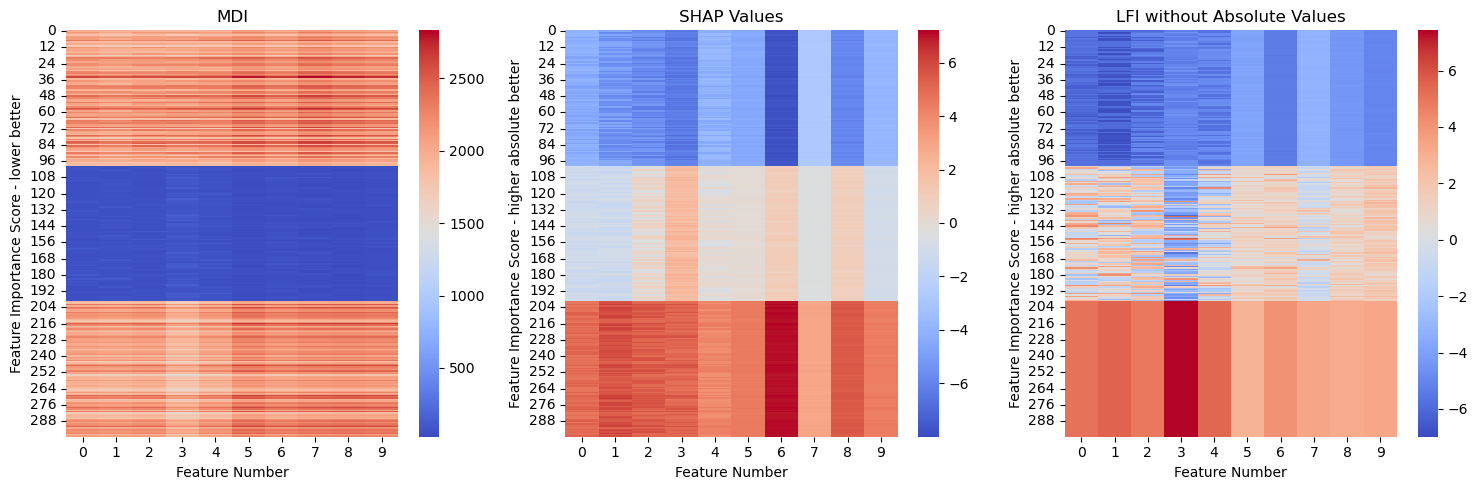

In [21]:
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X, y, local_scoring_fns=mean_squared_error, version="all", lfi=False)
plt.figure(figsize=(15, 5))  # Adjusted width to accommodate three plots side-by-side
plt.subplot(1, 3, 1)
sns.heatmap(mdi_plus_scores["local"], cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("MDI")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - lower better")

rf_regressor.fit(X, y)
shap_val = tree_shap_local(X, y, rf_regressor)
shap_val.columns = [f'{i}' for i in range(X.shape[1])]
plt.subplot(1, 3, 2)
sns.heatmap(shap_val, cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("SHAP Values")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - higher absolute better")

mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X, y, lfi=True, lfi_abs="none")
plt.subplot(1, 3, 3)
sns.heatmap(mdi_plus_scores["lfi"], cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("LFI without Absolute Values")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - higher absolute better")

plt.tight_layout() 
plt.show()

# With Raw

In [22]:
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_plus_model = RandomForestPlusRegressor(rf_model=copy.deepcopy(rf_regressor), include_raw=True)
rf_plus_model.fit(X, y)

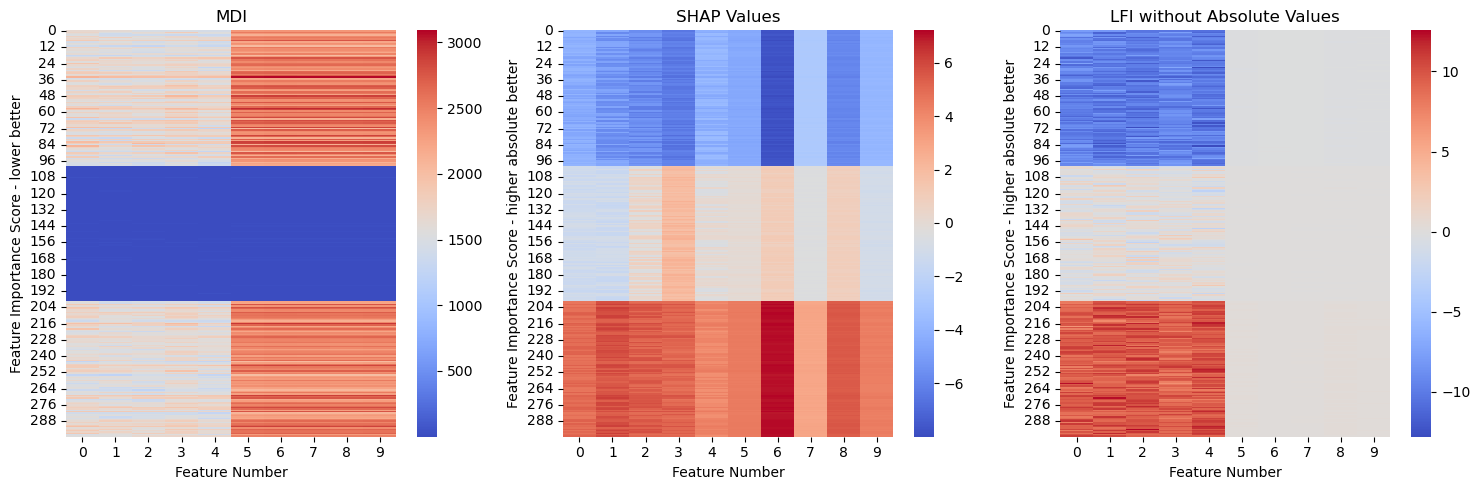

In [23]:
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X, y, local_scoring_fns=mean_squared_error, version="all", lfi=False)
plt.figure(figsize=(15, 5))  # Adjusted width to accommodate three plots side-by-side
plt.subplot(1, 3, 1)
sns.heatmap(mdi_plus_scores["local"], cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("MDI")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - lower better")

rf_regressor.fit(X, y)
shap_val = tree_shap_local(X, y, rf_regressor)
shap_val.columns = [f'{i}' for i in range(X.shape[1])]
plt.subplot(1, 3, 2)
sns.heatmap(shap_val, cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("SHAP Values")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - higher absolute better")

mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X, y, lfi=True, lfi_abs="none")
plt.subplot(1, 3, 3)
sns.heatmap(mdi_plus_scores["lfi"], cmap=coolwarm_camp, xticklabels="auto", yticklabels="auto")
plt.title("LFI without Absolute Values")
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance Score - higher absolute better")

plt.tight_layout() 
plt.show()

# Some linear regression analysis that I forget why we are doing this

In [24]:
# Fit linear regression for X and y
from sklearn.linear_model import LinearRegression
n = 300
d = 10
mean = [[0]*10,[10]*10,[20]*10]
scale = [[1]*10,[1]*10,[1]*10]
s = 5
X = sample_normal_X_subgroups(n, d, mean, scale)    
beta = np.concatenate((np.ones(s), np.zeros(d-s)))
y = np.matmul(X, beta)
lr = LinearRegression()
X_centered = X - X.mean(axis=0)
lr.fit(X_centered, y)

LinearRegression()

<Axes: >

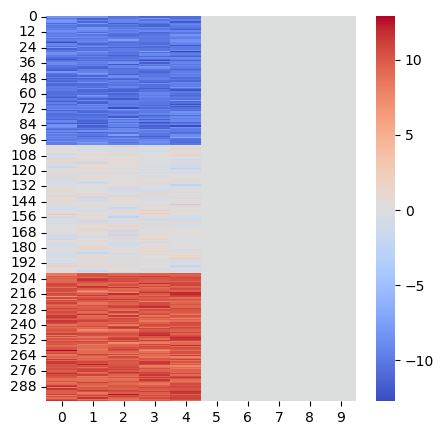

In [25]:
plt.figure(figsize=(5, 5))
sns.heatmap(X_centered*lr.coef_, cmap=coolwarm_camp)

In [26]:
lr.intercept_

49.957414833765